In [1]:
import pandas as pd

In [143]:
users = pd.read_pickle('../data/03_primary/users.pkl')

In [144]:
features = users[[
    "protected", "followers_count", "friends_count",  "listed_count", "favourites_count", "statuses_count",
    "verified", "default_profile", "default_profile_image",
]].copy()

features["has_location"] = users.location.isnull()
features["has_description"] = users.description.isnull()
features["created_at_time"] = pd.cut(users["created_at"].dt.hour, [-1, 6, 11, 18, 23], labels=["night", "morning", "day", "evening"])
features["account_active_for_days"] = (users["last_status_date"] - users["created_at"]).dt.days
features["has_banner"] = ~users["profile_banner_url"].isnull()
features["has_profile_url"] = ~users["profile_url"].isnull()
features["description_urls_count"] = users["description_urls"].str.len()
features["label"] = (users["label"] == 'bot').astype(int)

In [145]:
features["tweets_per_day"] = users["statuses_count"] / features["account_active_for_days"]
features["favourites_per_day"] = users["favourites_count"] / features["account_active_for_days"]
features["fr_to_flw_ratio"] = users["friends_count"] / users["followers_count"]
# features["faw_to_tweets_ratio"] = users["favourites_count"] / users["statuses_count"]
features["tweets_to_faw_ratio"] = users["statuses_count"] / users["favourites_count"]
features["listed_count_cat"] = pd.cut(users["listed_count"], [-1, 100, 500, 2000, 5000, 10000]).astype(str)
pd.cut(users["listed_count"], [-1, 100, 500, 2000, 5000, 10000]).value_counts()

(-1, 100]        26705
(100, 500]        3534
(500, 2000]       2999
(2000, 5000]      1787
(5000, 10000]      889
Name: listed_count, dtype: int64

In [146]:
features.to_pickle('../data/04_features/users.pkl')

In [87]:
pd.cut(users["created_at"].dt.hour, [-1, 9, 12, 18, 24], labels=["night", "morning", "day", "evening"]).value_counts()

night      13239
day        10570
evening     9755
morning     3013
Name: created_at, dtype: int64

In [63]:
pd.cut(users["created_at"].dt.hour, [-1, 6, 11, 18, 23], labels=["night", "morning", "day", "evening"]).value_counts()

day        11716
night      10534
evening     9755
morning     4572
Name: created_at, dtype: int64

In [55]:
(features["created_at_time"].astype(str) + ' ' + users["label"]).value_counts().tail(50)

day human        7805
night human      7189
evening human    6919
day bot          3911
night bot        3345
evening bot      2836
morning human    2618
morning bot      1954
dtype: int64

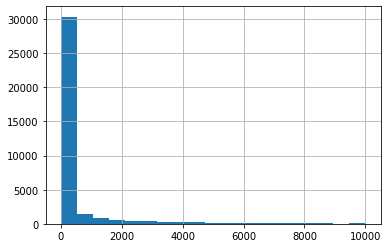

In [107]:
import numpy as np
users["listed_count"].hist(bins=np.linspace(-1, 10000, num=20))

In [70]:
features["listed_count"].value_counts()

0        9602
1        3669
2        2053
3        1381
4         986
         ... 
2803        1
4784        1
12948       1
2707        1
1519        1
Name: listed_count, Length: 4515, dtype: int64

In [150]:
features.dtypes

protected                      bool
followers_count               int64
friends_count                 int64
listed_count                  int64
favourites_count              int64
statuses_count                int64
verified                       bool
default_profile                bool
default_profile_image          bool
has_location                   bool
has_description                bool
created_at_time            category
account_active_for_days       int64
has_banner                     bool
has_profile_url                bool
description_urls_count        int64
label                         int64
tweets_per_day              float64
favourites_per_day          float64
fr_to_flw_ratio             float64
tweets_to_faw_ratio         float64
listed_count_cat             object
dtype: object